In [1]:
import os
from google.colab import files

# Download dataset
os.chdir('/content')
files.upload()  # Upload the kaggle.json file

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d alextamboli/unsw-nb15 -p /content/dataset/ --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alextamboli/unsw-nb15
License(s): unknown
 92% 145M/157M [00:01<00:00, 149MB/s]
100% 157M/157M [00:01<00:00, 120MB/s]


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Define column names based on the UNSW-NB15 dataset
columns = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
    'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
    'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
    'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
    'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
    'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
    'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label'
]

# Load UNSW-NB15 data
raw_file_folder = '/content/dataset/UNSW-NB15_c/'
data_files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv']
data_df = pd.concat([pd.read_csv(raw_file_folder + file, names=columns, low_memory=False) for file in data_files], ignore_index=True)

# Drop unnecessary columns: IP addresses, ports, and timestamps
data_df = data_df.drop(columns=['srcip', 'sport', 'dstip', 'dsport', 'Stime', 'Ltime'])

# Replace missing values in attack_cat with 'Normal'
data_df['attack_cat'] = data_df['attack_cat'].fillna('Normal')

# Drop any columns with only one unique value
for col in data_df.columns:
    if data_df[col].nunique() == 1:
        data_df.drop(col, axis=1, inplace=True)
        print(f'Dropped {col} column since it only has one unique value')

data_df_raw = data_df.copy()

# Handle missing or non-numeric values
data_df = data_df.dropna()

# Split into training and testing sets
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=42, stratify=data_df['attack_cat'])

# Combine for consistent preprocessing
data_df = pd.concat([train_df, test_df], ignore_index=True)

# Separate categorical and numerical columns
categorical_columns = ['proto', 'state', 'service', 'attack_cat']
numerical_columns = [col for col in data_df.columns if col not in categorical_columns and col != 'label']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_df[col] = le.fit_transform(data_df[col])
    label_encoders[col] = le  # Save the encoder for later use if needed

# Normalize numerical columns
scaler = StandardScaler()
data_df[numerical_columns] = scaler.fit_transform(data_df[numerical_columns])

# Split back into train and test sets
train_size = len(train_df)
train_data = data_df[:train_size]
test_data = data_df[train_size:]

# Separate features and labels
x_train_categ = train_data[categorical_columns[:-1]].values  # Exclude the 'attack_cat' column
x_train_numer = train_data[numerical_columns].values
y_train = train_data['attack_cat'].values

x_test_categ = test_data[categorical_columns[:-1]].values  # Exclude the 'attack_cat' column
x_test_numer = test_data[numerical_columns].values
y_test = test_data['attack_cat'].values

# Print the shapes to verify
print(f"x_train_categ shape: {x_train_categ.shape}")
print(f"x_train_numer shape: {x_train_numer.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test_categ shape: {x_test_categ.shape}")
print(f"x_test_numer shape: {x_test_numer.shape}")
print(f"y_test shape: {y_test.shape}")


x_train_categ shape: (761042, 3)
x_train_numer shape: (761042, 38)
y_train shape: (761042,)
x_test_categ shape: (326161, 3)
x_test_numer shape: (326161, 38)
y_test shape: (326161,)


In [3]:
# Calculate the final number of classes to classify
num_classes = len(label_encoders['attack_cat'].classes_)

# Mapping relationship between original string names and numerical values
attack_cat_mapping = {
    class_name: index
    for index, class_name in enumerate(label_encoders['attack_cat'].classes_)
}

# Print the results
print(f"Final Number of Classes to Classify: {num_classes}")
print("Mapping Relationship (Original Name -> Encoded Value):")
for class_name, index in attack_cat_mapping.items():
    print(f"{class_name} -> {index}")



Final Number of Classes to Classify: 10
Mapping Relationship (Original Name -> Encoded Value):
 Fuzzers -> 0
Analysis -> 1
Backdoors -> 2
DoS -> 3
Exploits -> 4
Generic -> 5
Normal -> 6
Reconnaissance -> 7
Shellcode -> 8
Worms -> 9


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the data to PyTorch tensors
x_train_categ_tensor = torch.tensor(x_train_categ, dtype=torch.long)
x_train_numer_tensor = torch.tensor(x_train_numer, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(x_train_categ_tensor, x_train_numer_tensor, y_train_tensor)

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [5]:
!rm transformer.py
!rm ft_transformer.py
!wget https://raw.githubusercontent.com/RealDanielWei/MLModels/master/transformer.py
!wget https://raw.githubusercontent.com/RealDanielWei/MLModels/master/ft_transformer.py

rm: cannot remove 'transformer.py': No such file or directory
rm: cannot remove 'ft_transformer.py': No such file or directory
--2024-11-21 19:45:48--  https://raw.githubusercontent.com/RealDanielWei/MLModels/master/transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7994 (7.8K) [text/plain]
Saving to: ‘transformer.py’

transformer.py      100%[===================>]   7.81K  --.-KB/s    in 0s      

2024-11-21 19:45:49 (101 MB/s) - ‘transformer.py’ saved [7994/7994]

--2024-11-21 19:45:49--  https://raw.githubusercontent.com/RealDanielWei/MLModels/master/ft_transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserc

In [ ]:
del model

In [6]:
from ft_transformer import FTTransformer

categories = [data_df[col].nunique() for col in categorical_columns[:-1]]  # Unique values per categorical column
num_continuous = len(numerical_columns)  # Number of continuous features

# Initialize FTTransformer with the correct output dimension for multi-class classification
model = FTTransformer(
    categories=categories,      # List of unique values for each categorical feature
    num_continuous=num_continuous,  # Number of continuous features
    dim=10,                    # Embedding dimension
    depth=8,                   # Number of Transformer layers
    heads=4,                   # Number of attention heads
    dim_head=4,               # Dimension of each attention head
    dim_out=num_classes,        # Set output dimension to the number of classes
    num_special_tokens=1,      # Number of special tokens (CLS, etc.)
    attn_dropout=0.1,          # Dropout for attention
    ff_dropout=0.1             # Dropout for feedforward layers
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
print(f"Total number of parameters: {count_parameters(model)}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Total number of parameters: 18310


device = cuda
Epoch 1/50
Training Loss: 0.0483
Validation Loss: 0.0224, Accuracy: 0.9914
Model saved with better validation accuracy
Epoch 2/50
Training Loss: 0.0210
Validation Loss: 0.0198, Accuracy: 0.9919
Model saved with better validation accuracy
Epoch 3/50
Training Loss: 0.0199
Validation Loss: 0.0186, Accuracy: 0.9924
Model saved with better validation accuracy
Epoch 4/50
Training Loss: 0.0191
Validation Loss: 0.0180, Accuracy: 0.9926
Model saved with better validation accuracy
Epoch 5/50
Training Loss: 0.0187
Validation Loss: 0.0174, Accuracy: 0.9929
Model saved with better validation accuracy
Epoch 6/50
Training Loss: 0.0184
Validation Loss: 0.0172, Accuracy: 0.9931
Model saved with better validation accuracy
Epoch 7/50
Training Loss: 0.0181
Validation Loss: 0.0172, Accuracy: 0.9929
Epoch 8/50
Training Loss: 0.0180
Validation Loss: 0.0170, Accuracy: 0.9931
Model saved with better validation accuracy
Epoch 9/50
Training Loss: 0.0177
Validation Loss: 0.0175, Accuracy: 0.9929
Epo

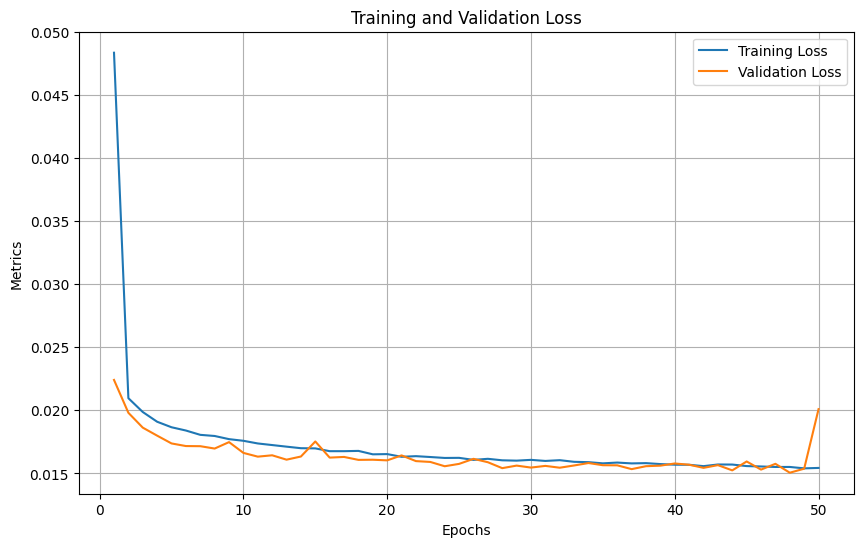

In [7]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize lists to store losses, accuracies, and F1 scores
train_losses = []
val_losses = []
val_accuracies = []

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for x_categ, x_numer, labels in train_loader:
        # Move inputs and labels to the device (GPU or CPU)
        x_categ, x_numer, labels = x_categ.to(device), x_numer.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_categ, x_numer)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")


def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for x_categ, x_numer, labels in val_loader:
            x_categ, x_numer, labels = x_categ.to(device), x_numer.to(device), labels.to(device)

            # Forward pass
            outputs = model(x_categ, x_numer)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Store predictions and labels for accuracy and F1 calculation
            _, preds = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
    return accuracy

# Training the model over several epochs
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')
best_val_acc = 0.0
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate after each epoch
    val_acc = validate(model, val_loader, criterion, device)

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_ft_transformer_model.pth")
        print("Model saved with better validation accuracy")

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')


plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import classification_report
import torch

# Function to test the model
def test_model(model, x_test_categ, x_test_numer, y_test, batch_size=64):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    # Convert test data to tensors
    x_test_categ_tensor = torch.tensor(x_test_categ, dtype=torch.long)
    x_test_numer_tensor = torch.tensor(x_test_numer, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for batch processing
    test_dataset = torch.utils.data.TensorDataset(x_test_categ_tensor, x_test_numer_tensor, y_test_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():  # No gradient calculation during testing
        for x_categ, x_numer, y in test_loader:
            # Forward pass
            logits = model(x_categ.to(device), x_numer.to(device))
            predictions = torch.argmax(logits, dim=1)  # Get class predictions
            y_true.extend(y.tolist())
            y_pred.extend(predictions.tolist())

    # Calculate classification metrics
    report = classification_report(y_true, y_pred, target_names=label_encoders['attack_cat'].classes_)

    # Print the number of parameters in the model
    print(f"Total number of parameters: {count_parameters(model)}")
    print("Classification Report:\n", report)

# Run the test
test_model(model, x_test_categ, x_test_numer, y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Total number of parameters: 18310
Classification Report:
                 precision    recall  f1-score   support

       Fuzzers       0.59      0.63      0.61      1515
      Analysis       0.00      0.00      0.00       158
     Backdoors       0.00      0.00      0.00       160
           DoS       0.54      0.05      0.10       350
      Exploits       0.57      0.88      0.69      1623
       Generic       0.94      0.96      0.95      2257
        Normal       1.00      1.00      1.00    319496
Reconnaissance       0.77      0.38      0.51       528
     Shellcode       0.09      0.28      0.14        67
         Worms       0.00      0.00      0.00         7

      accuracy                           0.99    326161
     macro avg       0.45      0.42      0.40    326161
  weighted avg       0.99      0.99      0.99    326161



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report

def train_and_test_baseline(x_train_categ, x_train_numer, y_train, x_test_categ, x_test_numer, y_test):
  # Combine categorical and numerical features for training and testing
  x_train_baseline = np.hstack((x_train_categ, x_train_numer))
  x_test_baseline = np.hstack((x_test_categ, x_test_numer))

  # Convert labels to integers if they are not already
  y_train_baseline = y_train.astype(int)
  y_test_baseline = y_test.astype(int)

  # Create XGBoost DMatrix for better performance
  dtrain = xgb.DMatrix(x_train_baseline, label=y_train_baseline)
  dtest = xgb.DMatrix(x_test_baseline, label=y_test_baseline)

  # Set XGBoost parameters
  params = {
      'objective': 'multi:softmax',  # Use softmax for multi-class classification
      'num_class': num_classes,     # Number of classes
      'eval_metric': 'mlogloss',    # Log loss for evaluation
      'max_depth': 4,               # Max depth of trees
      'eta': 0.3,                   # Learning rate
      'seed': 42                    # Random seed
  }

  # Train the XGBoost model
  num_rounds = 100  # Number of boosting rounds
  bst = xgb.train(params, dtrain, num_rounds)

  # Print the number of parameters in the baseline model
  num_parameters_baseline = sum(tree.count('\n') for tree in bst.get_dump())
  print(f"Total number of baseline parameters: {num_parameters_baseline}")

  # Make predictions
  y_pred = bst.predict(dtest)

  # Detailed classification report
  print("Classification Report:\n", classification_report(y_test, y_pred))

train_and_test_baseline(x_train_categ, x_train_numer, y_train, x_test_categ, x_test_numer, y_test)

Total number of baseline parameters: 19688
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65      1515
           1       0.00      0.00      0.00       158
           2       0.00      0.00      0.00       160
           3       0.45      0.14      0.21       350
           4       0.62      0.83      0.71      1623
           5       0.98      0.96      0.97      2257
           6       1.00      1.00      1.00    319496
           7       0.94      0.89      0.92       528
           8       0.53      0.54      0.53        67
           9       0.33      0.14      0.20         7

    accuracy                           0.99    326161
   macro avg       0.55      0.52      0.52    326161
weighted avg       0.99      0.99      0.99    326161

